# S&P500 Index Prediction

## Introduction
In this project, I will conduct a time series analysis for S&P500 Index. The main research goal is to find out:
1.	Can the prices of S&P500 be predicted by its own history?
2.	Can the prices of S&P500 be predicted by other factors, such as federal interest rate, Consumer Price Index (CPI), and unemployment rate?

## Methods
I will use the below models for this project:
1.	ADF model: making sure the data are stationary.  
2.	ARIMA model on S&P500: finding out how the historical prices explain the prices in a given time series
3.	Vector Auto Regression (VAR): exploring multivariate time series. A Multivariate time series has more than one time-dependent variable. Each variable depends not only on its past values but also has some dependency on other variables. This dependency is used for forecasting future values. 
4. Durbin Watson Model: Check for Serial Correlation of Residuals (Errors) 

In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sklearn
import scipy.stats as stats
import seaborn as sns
import datetime 
import statsmodels

In [226]:
df = pd.read_csv(r'C:\Users\ojiang1\Desktop\Data Science\Capstone4_S&P500 Index Prediction\sp500.csv')

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17736 entries, 0 to 17735
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               17736 non-null  object 
 1   SPClose            17736 non-null  float64
 2   fedrate            16612 non-null  float64
 3   CPI                15225 non-null  float64
 4   unemployment_rate  17716 non-null  float64
dtypes: float64(4), object(1)
memory usage: 692.9+ KB


In [228]:
df.head()

,Date,SPClose,fedrate,CPI,unemployment_rate
0,1/3/1950,16.66,NaN,NaN,6.5
1,1/4/1950,16.85,NaN,NaN,6.5
2,1/5/1950,16.93,NaN,NaN,6.5
3,1/6/1950,16.98,NaN,NaN,6.5
4,1/9/1950,17.08,NaN,NaN,6.5


In [229]:
# Set date time index
df.index = pd.to_datetime(df.Date)
df=df.drop(['Date'], axis=1)

In [230]:
df.head()

,SPClose,fedrate,CPI,unemployment_rate
Date,,,,
1950-01-03,16.66,NaN,NaN,6.5
1950-01-04,16.85,NaN,NaN,6.5
1950-01-05,16.93,NaN,NaN,6.5
1950-01-06,16.98,NaN,NaN,6.5
1950-01-09,17.08,NaN,NaN,6.5


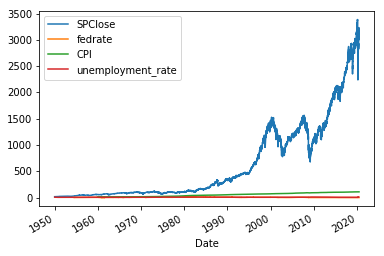

In [231]:
df.plot()

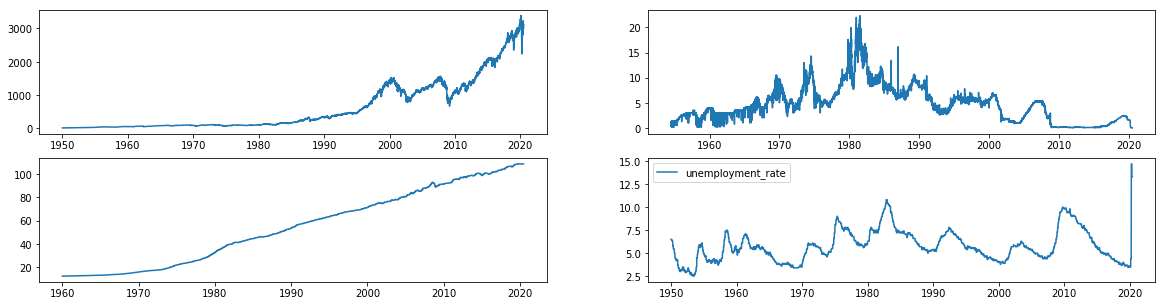

In [232]:
plt.figure(figsize=(20,5))

plt.subplot(2,2,1)
plt.plot(df.SPClose)

plt.subplot(2,2,2)
plt.plot(df.fedrate)

plt.subplot(2,2,3)
plt.plot(df.CPI)

plt.subplot(2,2,4)
plt.plot(df.unemployment_rate)
plt.legend()

In [233]:
df.describe()

,SPClose,fedrate,CPI,unemployment_rate
count,17736.000000,16612.000000,15225.000000,17716.000000
mean,618.893844,4.743985,54.615073,5.775943
std,751.676764,3.618512,31.470626,1.692291
min,16.660000,0.000000,12.360000,2.500000
25%,86.655000,2.000000,22.230000,4.600000
50%,181.310000,4.400000,54.380000,5.600000
75%,1122.705000,6.490000,82.060000,6.900000
max,3386.150000,22.360000,108.580000,14.700000


# Q1. Can the prices of S&P500 be predicted by its own history?

In [234]:
# create a new dataframe only contain sp500 data
# drop fedrate, CPI, unemployment_rate 

df1 = df.drop(['fedrate', 'CPI', 'unemployment_rate'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17736 entries, 1950-01-03 to 2020-06-26
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SPClose  17736 non-null  float64
dtypes: float64(1)
memory usage: 277.1 KB


In [235]:
 df1.head()

,SPClose
Date,
1950-01-03,16.66
1950-01-04,16.85
1950-01-05,16.93
1950-01-06,16.98
1950-01-09,17.08


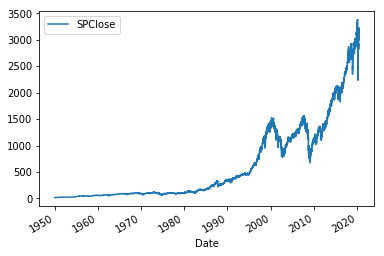

In [236]:
df1.plot()

# 1. Seasonal Decomposition
Let's dig a little deeper and do some time-series decomposition. 

Time-series data is made up of systematic and non-systematic components. 

Systematic components can be modeled and include:
1. Trend: direction of overall change
2. Seasonality: repeating cycles over a shorter period of time

Non-systematic components come from error and randomness in the data and can't be modeled.

StatsModels has a seasonal_decompose() function that provides a naive decomposition using either an additive (linear) or multiplicative (non-linear) model. 

Based the above plot, we see some multiplicative behavior, so we'll decompose the data using an multiplicative model.

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose


sp_Weekly


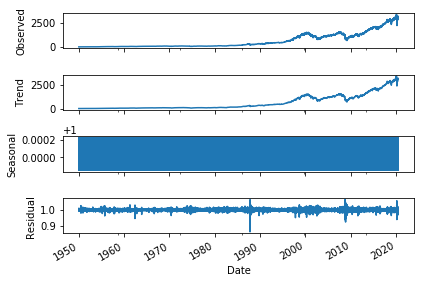

sp_Quarterly


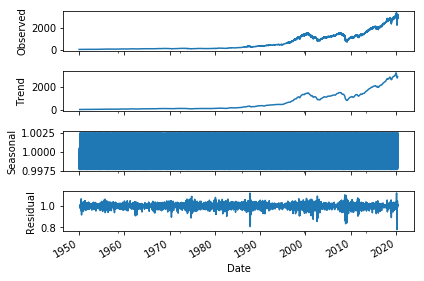

sp_Yearly


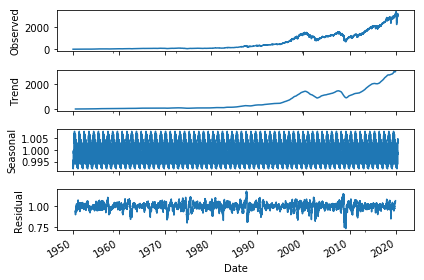

In [23]:
# Weekly: 5 trading days/week
print('sp_Weekly')
weekly_decompose = seasonal_decompose(df1.SPClose.dropna(), model='multiplicative', freq=(5)) 
weekly_decompose.plot()
plt.show()


# Quarterly: 5*52/4 = 65 
print('sp_Quarterly')
quarterly_decompose = seasonal_decompose(df1.SPClose.dropna(), model='multiplicative', freq=(65)) 
quarterly_decompose.plot()
plt.show()


# Yearly: 5 trading days/week, 52 weeks/year, will disregard holidays here
print('sp_Yearly')
yearly_decompose = seasonal_decompose(df1.SPClose.dropna(), model='multiplicative', freq=(5*52)) 
yearly_decompose.plot()
plt.show()

Trend very closely resemble the obvserved series.
Trend explains most of the variability of the data.

Seasonal: constantly switch up up and down, ie, no concrete cyclicle pattern.

Residual: around 1.

Overall, the decomposition suggests NO seasonality in the data

# 2. Model Preparation
Let's start our modeling process with creating training and testing data. 

Unlike traditional supervised learning models where we randomly split the data, our training and testing data sets needs to remain sequential to preserve time dependency. 

We'll do a 80/20 spilt with the last 20% data as testing set.

In [237]:
train = df1.SPClose[:-int(len(df.SPClose)*0.2)]
test = df1.SPClose[len(df.SPClose)-int(len(df.SPClose)*0.2):]

print('train:', len(train), 
      '\n test:', len(test))

train: 14189 
 test: 3547


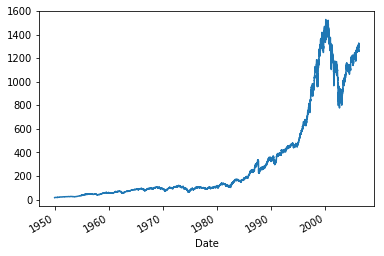

In [238]:
train.plot()

In [168]:
train

Date
1950-01-03      16.66
1950-01-04      16.85
1950-01-05      16.93
1950-01-06      16.98
1950-01-09      17.08
               ...   
2006-05-18    1261.81
2006-05-19    1267.03
2006-05-22    1262.07
2006-05-23    1256.58
2006-05-24    1258.57
Name: SPClose, Length: 14189, dtype: float64

In [177]:
test

Date
2006-05-25    1272.88
2006-05-26    1280.16
2006-05-30    1259.87
2006-05-31    1270.09
2006-06-01    1285.71
               ...   
2020-06-22    3117.86
2020-06-23    3131.29
2020-06-24    3050.33
2020-06-25    3083.76
2020-06-26    3009.05
Name: SPClose, Length: 3547, dtype: float64

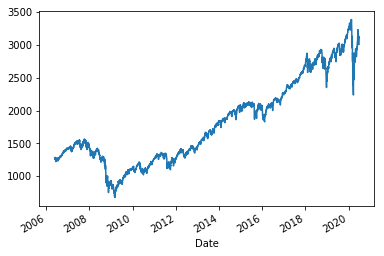

In [239]:
test.plot()

# 3. Stationarity Tests
Before we model, it's important to test for stationarity. Stationarity tests a data set for mean and variance stability through time. If the mean and variance are not time dependent, the data is stationary.

The Augmented Dickey-Fuller (ADF) test is a formal statistical test for stationarity. The null hypothesis assumes non-stationarity. 
If p < 0.05, we reject the null and assume the alternate hypothesis of stationarity. 
If p > 0.05, we accept the null of non-stationarity.

A non-stationary data set can be made stationary by differencing.

In [240]:
from statsmodels.tsa.stattools import adfuller

In [241]:
# write a function for future reuse

def stationarity_test(name, x):
    result = adfuller(x)
    print(name,':')
    print('ADF Statistic %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print('{} data set is NOT stationary, differencing required!\n'.format(name))
    else:
        print('{} is stationary\n'.format(name))

In [242]:
stationarity_test('Train', train)

Train :
ADF Statistic 1.500446
p-value: 0.997526
Train data set is NOT stationary, differencing required!



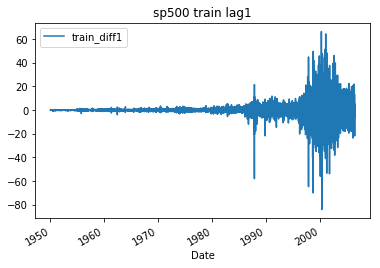

In [243]:
# since it is not stationary, the lets do the differencing 

df1['train_diff1'] = train - train.shift()
df1.plot(y='train_diff1')
plt.title('sp500 train lag1')
plt.show()


In [244]:
stationarity_test('train_diff1', df1['train_diff1'].dropna())

train_diff1 :
ADF Statistic -21.486117
p-value: 0.000000
train_diff1 is stationary



As a result, we will apply lag 1 differencing to the data sets in the ARIMA models below.

# 4. ARIMA
-Autoregressive (AR/p): Number of lag terms to build a simple linear model on. Looks at p past values.
-Integrated (I/d): Degree of differencing needed to make the data stationary.
-Moving Average (MA/q): Number of lag terms to look at for moving average. Looks at error terms from q past values.


## 4.1 ACF/PACF Plots
-PACF plots show correlations between a value and error from previous lags, providing estimates for AR(p).

-ACF plots show correlations between a series and its lags, providing estimates for MA(q). 


In [245]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [246]:
# write a function for future reuse

def arima_model(name, x):
    plot_acf(pd.Series(x), lags=40, alpha=.05)
    plt.title('{} - ACF-MA(q)'.format(name))
    plt.show()

    plot_pacf(pd.Series(x), lags=40, alpha=0.05)
    plt.title('{} - PACF-AR(p)'.format(name))
    plt.show()

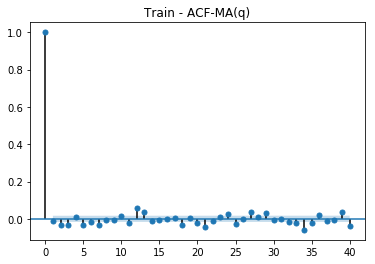

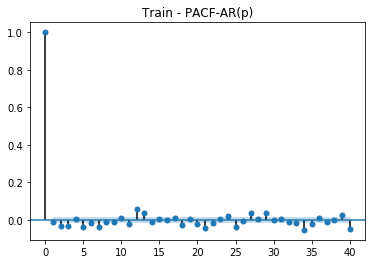

In [247]:
arima_model('Train', df1['train_diff1'].dropna())


From these plots, we can obtain reasonable starting parameters and then build up a grid search to find the best combination.

Grid search starting point:

AR(p) = range(1,4)
I(d) = [1]
MA(q) = range(1,4)

## 4.2 Model configs
Next I'll write some functions to search the best params for ARIMA model. 

Typically, we look at the AIC to evalute a model, choosing the model with the lowest AIC score. However, getting AIC values over a rather expansive grid seach takes a lot of work and involves manually reading model output tables. 

To automate this process, I'll instead use each model to make predictions and test those predictions against known values, and then select a model that miminizes mean squared error.

I'll also examine residuals from the optimized model configuration. I want to see that our error terms are random and normally distributed.

In [248]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [249]:
# residual evatluation

def plot_residuals(name, train, p, d, q):
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    residuals = model_fit.resid
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('{}: {},{},{} Residuals'.format(name, p, d, q))
    residuals.plot()
    
    plt.subplot(1,2,2)
    residuals.hist(bins=25)
    plt.title('{} Residual Histogram'.format(name))
    plt.show()


In [112]:
model_010 = ARIMA(train, order=(0,1,0))
model_010_fit = model_010.fit()
print(model_010_fit.summary())
print('Residuals Description')
print(model_010_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:              D.SPClose   No. Observations:                14188
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -44575.290
Method:                           css   S.D. of innovations              5.600
Date:                Wed, 01 Jul 2020   AIC                          89154.581
Time:                        15:12:43   BIC                          89169.701
Sample:                             1   HQIC                         89159.611
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0875      0.047      1.862      0.063      -0.005       0.180
Residuals Description
count    1.418800e+04
mean     4.024065e-15
std      5.600504e+00
min     -8.403753e+01
25%     -6.075324e-01

In [113]:
model_110 = ARIMA(train, order=(1,1,0))
model_110_fit = model_110.fit()
print(model_110_fit.summary())
print('Residuals Description')
print(model_110_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:              D.SPClose   No. Observations:                14188
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -44574.608
Method:                       css-mle   S.D. of innovations              5.600
Date:                Wed, 01 Jul 2020   AIC                          89155.217
Time:                        15:13:21   BIC                          89177.897
Sample:                             1   HQIC                         89162.763
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0875      0.047      1.880      0.060      -0.004       0.179
ar.L1.D.SPClose    -0.0098      0.008     -1.168      0.243      -0.026       0.007
                                

In [114]:
model_111 = ARIMA(train, order=(1,1,1))
model_111_fit = model_111.fit()
print(model_111_fit.summary())
print('Residuals Description')
print(model_111_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:              D.SPClose   No. Observations:                14188
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -44555.967
Method:                       css-mle   S.D. of innovations              5.593
Date:                Wed, 01 Jul 2020   AIC                          89119.935
Time:                        15:13:54   BIC                          89150.175
Sample:                             1   HQIC                         89129.996
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0878      0.039      2.242      0.025       0.011       0.165
ar.L1.D.SPClose     0.8198      0.046     17.742      0.000       0.729       0.910
ma.L1.D.SPClose    -0.8497      

In [115]:
model_114 = ARIMA(train, order=(1,1,4))
model_114_fit = model_114.fit()
print(model_114_fit.summary())
print('Residuals Description')
print(model_114_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:              D.SPClose   No. Observations:                14188
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -44550.706
Method:                       css-mle   S.D. of innovations              5.591
Date:                Wed, 01 Jul 2020   AIC                          89115.412
Time:                        15:14:13   BIC                          89168.333
Sample:                             1   HQIC                         89133.018
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0877      0.040      2.208      0.027       0.010       0.166
ar.L1.D.SPClose     0.7472      0.091      8.201      0.000       0.569       0.926
ma.L1.D.SPClose    -0.7593      

In [116]:
model_411 = ARIMA(train, order=(4,1,1))
model_411_fit = model_411.fit()
print(model_411_fit.summary())
print('Residuals Description')
print(model_411_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:              D.SPClose   No. Observations:                14188
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -44550.992
Method:                       css-mle   S.D. of innovations              5.591
Date:                Wed, 01 Jul 2020   AIC                          89115.984
Time:                        15:14:37   BIC                          89168.905
Sample:                             1   HQIC                         89133.591
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0877      0.040      2.209      0.027       0.010       0.166
ar.L1.D.SPClose     0.7749      0.075     10.342      0.000       0.628       0.922
ar.L2.D.SPClose    -0.0258      

In [250]:
model_414 = ARIMA(train, order=(4,1,4))
model_414_fit = model_414.fit()
print(model_414_fit.summary())
print('Residuals Description')
print(model_414_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:              D.SPClose   No. Observations:                14188
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -44504.043
Method:                       css-mle   S.D. of innovations              5.571
Date:                Fri, 03 Jul 2020   AIC                          89028.087
Time:                        10:26:48   BIC                          89103.688
Sample:                             1   HQIC                         89053.239
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0872      0.045      1.931      0.054      -0.001       0.176
ar.L1.D.SPClose    -0.0931      0.005    -18.877      0.000      -0.103      -0.083
ar.L2.D.SPClose     1.4169      

Based on AIC score and p values, model ARIMA(4,1,4) perform the best.

Now I'll check the residuals.

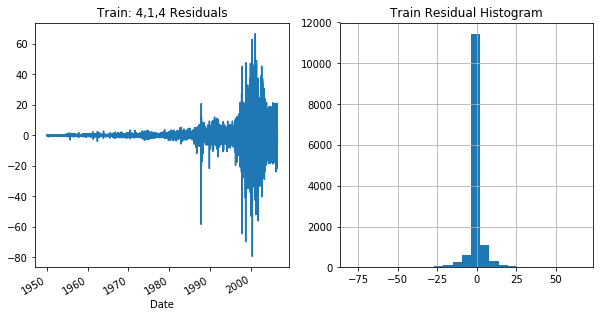

In [251]:
plot_residuals('Train', train, 4, 1, 4)

The residule is random and oscillating.

# 5. Plot of Forecast vs Actual

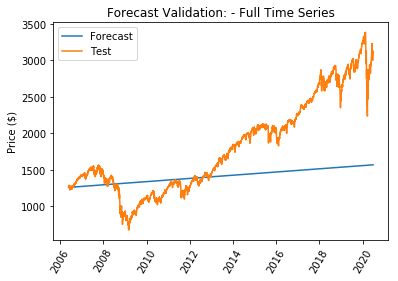

In [254]:
# forecast on test set

y_fc = model_414_fit.forecast(len(test))[0]

df_forecast = pd.DataFrame(y_fc, index=df.index[-len(test):])

plt.plot(df_forecast,label='Forecast')
plt.plot(test, label='Test')
#plt.plot(train.index, train, label='Train')

plt.title('Forecast Validation: - Full Time Series')
plt.ylabel('Price ($)')
plt.xticks(rotation=60)
plt.legend()

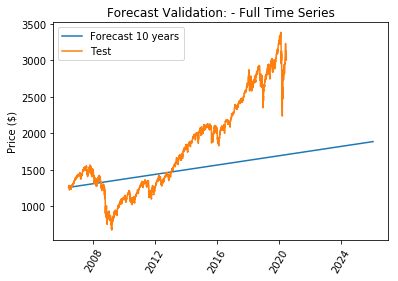

In [256]:
#  forecast on test + 10 years

y_fc = model_414_fit.forecast(len(test)+3650)[0]

df_forecast1 = pd.DataFrame(y_fc, index=pd.date_range(start='2006-05-25', periods=len(y_fc), freq='D'))
plt.plot(df_forecast1, label='Forecast 10 years')

plt.plot(test, label='Test')

plt.title('Forecast Validation: - Full Time Series')
plt.ylabel('Price ($)')
plt.xticks(rotation=60)
plt.legend()

# Q2. Can the prices of S&P500 be predicted by other factors, such as federal interest rate, Consumer Price Index (CPI), and unemployment rate?

In [257]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tools.eval_measures import rmse, aic


In [258]:
df.head()

,SPClose,fedrate,CPI,unemployment_rate
Date,,,,
1950-01-03,16.66,NaN,NaN,6.5
1950-01-04,16.85,NaN,NaN,6.5
1950-01-05,16.93,NaN,NaN,6.5
1950-01-06,16.98,NaN,NaN,6.5
1950-01-09,17.08,NaN,NaN,6.5


Since Fedrate and CPI do not have history record before 1954, instead of impute the NaN value, I chose to drop them. 

In [259]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15205 entries, 1960-01-04 to 2020-05-29
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SPClose            15205 non-null  float64
 1   fedrate            15205 non-null  float64
 2   CPI                15205 non-null  float64
 3   unemployment_rate  15205 non-null  float64
dtypes: float64(4)
memory usage: 593.9 KB


# 1. Visualize the Time Series

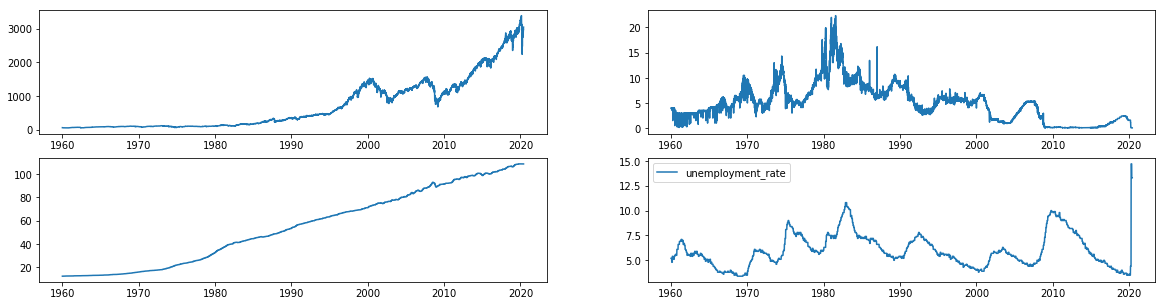

In [260]:
plt.figure(figsize=(20,5))

plt.subplot(2,2,1)
plt.plot(df.SPClose)

plt.subplot(2,2,2)
plt.plot(df.fedrate)

plt.subplot(2,2,3)
plt.plot(df.CPI)

plt.subplot(2,2,4)
plt.plot(df.unemployment_rate)
plt.legend()

From the plot, SP500 price and CPI have a similar trend, while fedrate and unemployment rate have a oscillating behavior.

# 2.  Split theTraining and Testing Data
The VAR model will be fitted on train and then used to forecast test observations. These forecasts will be compared against the actual present in test data.

In [261]:
train = df[:-int(len(df)*0.2)]
test = df[len(df)-int(len(df)*0.2):]

print('train:', len(train), 
      '\n test:', len(test))

train: 12164 
 test: 3041


In [292]:
test

,SPClose,fedrate,CPI,unemployment_rate
Date,,,,
2008-05-01,1409.34,2.16,91.40,5.4
2008-05-02,1413.90,1.88,91.40,5.4
2008-05-05,1407.49,1.85,91.40,5.4
2008-05-06,1418.26,1.91,91.40,5.4
2008-05-07,1392.57,2.01,91.40,5.4
...,...,...,...,...
2020-05-22,2955.45,0.05,108.52,13.3
2020-05-26,2991.77,0.05,108.52,13.3
2020-05-27,3036.13,0.05,108.52,13.3


# 3. Check for Stationarity and Make the Time Series Stationary

In [262]:
def adfuller_test(series, signif=0.05, name='', verbose=False): 
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [263]:
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "SPClose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.9892
 No. Lags Chosen       = 40
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.9942. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "fedrate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8672
 No. Lags Chosen       = 39
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0493. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

The ADF test confirms 3 out of 4 of the time series is non stationary. 

The one that is stationary is very close to 0.05. 

Considering All of the series in the VAR model should have the same number of observations, I will difference all of them once and check again.

In [264]:
# 1st difference
train_diff1 = train.diff().dropna()
train_diff1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12163 entries, 1960-01-05 to 2008-04-30
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SPClose            12163 non-null  float64
 1   fedrate            12163 non-null  float64
 2   CPI                12163 non-null  float64
 3   unemployment_rate  12163 non-null  float64
dtypes: float64(4)
memory usage: 475.1 KB


In [265]:
# Re-run ADF test on each differenced series.

for name, column in train_diff1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "SPClose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.4561
 No. Lags Chosen       = 39
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "fedrate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.3712
 No. Lags Chosen       = 38
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

All the series are now stationary.

# 4. Var model order(p) selection
To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

In [266]:
model = VAR(train_diff1)

x = model.select_order(maxlags=30)
x.summary()

,AIC,BIC,FPE,HQIC
0,-10.53,-10.52,2.680e-05,-10.53
1,-10.59,-10.58,2.516e-05,-10.59
2,-10.64,-10.61,2.405e-05,-10.63
3,-10.68,-10.65,2.305e-05,-10.67
4,-10.70,-10.66,2.256e-05,-10.69
5,-10.70,-10.65,2.253e-05,-10.68
6,-10.71,-10.65,2.229e-05,-10.69
7,-10.73,-10.66,2.192e-05,-10.70
8,-10.74,-10.66*,2.163e-05,-10.71
9,-10.74,-10.65,2.163e-05,-10.71


Lag 24 has the lowest AIC and FPE score. So I will use 24 as the order.

# 5. Train the Var model of seclected order (24)

In [267]:
model_fitted = model.fit(24)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Jul, 2020
Time:                     10:32:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -10.6289
Nobs:                     12139.0    HQIC:                  -10.7862
Log likelihood:          -2561.59    FPE:                1.91054e-05
AIC:                     -10.8655    Det(Omega_mle):     1.85068e-05
--------------------------------------------------------------------
Results for equation SPClose
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.222347         0.079343            2.802           0.005
L1.SPClose                   -0.036223         0.009115           -3.974           0.000
L1.fedrate                

# 6. Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. 

In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [118]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

SPClose : 2.0
fedrate : 2.0
CPI : 2.0
unemployment_rate : 2.0


The serial correlation seems quite alright. Let’s proceed with the forecast.

# 7. Forecast VAR model using statsmodels
In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [268]:
# Get the lag order

lag_order = model_fitted.k_ar
print(lag_order)  

24


In [269]:
# Input data for forecasting

forecast_input = train_diff1.values[-lag_order:]
forecast_input

array([[-1.054e+01, -1.800e-01,  0.000e+00,  0.000e+00],
       [ 7.480e+00,  4.200e-01,  0.000e+00,  0.000e+00],
       [ 4.748e+01, -1.300e-01,  5.500e-01, -1.000e-01],
       [-2.650e+00, -2.000e-01,  0.000e+00,  0.000e+00],
       [ 1.780e+00,  1.000e-02,  0.000e+00,  0.000e+00],
       [ 1.090e+00,  7.000e-02,  0.000e+00,  0.000e+00],
       [ 2.140e+00, -2.000e-02,  0.000e+00,  0.000e+00],
       [-7.000e+00, -1.000e-02,  0.000e+00,  0.000e+00],
       [-1.105e+01, -3.000e-02,  0.000e+00,  0.000e+00],
       [ 6.060e+00,  1.000e-01,  0.000e+00,  0.000e+00],
       [-2.772e+01,  7.000e-02,  0.000e+00,  0.000e+00],
       [-4.510e+00, -5.000e-02,  0.000e+00,  0.000e+00],
       [ 6.110e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 3.028e+01,  3.000e-02,  0.000e+00,  0.000e+00],
       [ 8.500e-01,  2.000e-02,  0.000e+00,  0.000e+00],
       [ 2.477e+01, -5.000e-02,  0.000e+00,  0.000e+00],
       [-2.160e+00, -4.000e-02,  0.000e+00,  0.000e+00],
       [-1.223e+01, -2.900e-01,

In [270]:
# Forecast on test data

nobs=int(len(df)*0.2)

fc = model_fitted.forecast(y=forecast_input, steps=nobs)

df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,SPClose_1d,fedrate_1d,CPI_1d,unemployment_rate_1d
Date,,,,
2008-05-01,0.304965,0.120650,0.108022,0.014393
2008-05-02,3.684527,-0.099036,0.055716,-0.004412
2008-05-05,-0.184691,-0.153083,0.000699,-0.004562
2008-05-06,0.321478,-0.044043,-0.006941,-0.002678
2008-05-07,1.542922,0.070505,0.000303,0.003782
...,...,...,...,...
2020-05-22,0.109697,-0.000165,0.006464,0.000019
2020-05-26,0.109697,-0.000165,0.006464,0.000019
2020-05-27,0.109697,-0.000165,0.006464,0.000019


The forecasts are generated but it is on the scale of the training data used by the model. 
So, to bring it back up to its original scale, I need to de-difference it as many times I had differenced the original input data. 

In this case, just once.

In [271]:
def invert_transformation(train, df_forecast):

    df_fc = df_forecast.copy()
    columns = train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [272]:
df_results = invert_transformation(train, df_forecast)

In [273]:
df_results

,SPClose_1d,fedrate_1d,CPI_1d,unemployment_rate_1d,SPClose_forecast,fedrate_forecast,CPI_forecast,unemployment_rate_forecast
Date,,,,,,,,
2008-05-01,0.304965,0.120650,0.108022,0.014393,1385.894965,2.490650,90.748022,5.014393
2008-05-02,3.684527,-0.099036,0.055716,-0.004412,1389.579493,2.391614,90.803738,5.009981
2008-05-05,-0.184691,-0.153083,0.000699,-0.004562,1389.394802,2.238531,90.804437,5.005419
2008-05-06,0.321478,-0.044043,-0.006941,-0.002678,1389.716280,2.194488,90.797496,5.002741
2008-05-07,1.542922,0.070505,0.000303,0.003782,1391.259202,2.264994,90.797799,5.006523
...,...,...,...,...,...,...,...,...
2020-05-22,0.109697,-0.000165,0.006464,0.000019,1720.634590,1.803292,110.409643,5.063642
2020-05-26,0.109697,-0.000165,0.006464,0.000019,1720.744287,1.803127,110.416107,5.063662
2020-05-27,0.109697,-0.000165,0.006464,0.000019,1720.853984,1.802963,110.422571,5.063681


The forecasts are back to the original scale. Let’s plot the forecasts against the actuals from test data.

# 8. Plot of Forecast vs Actuals

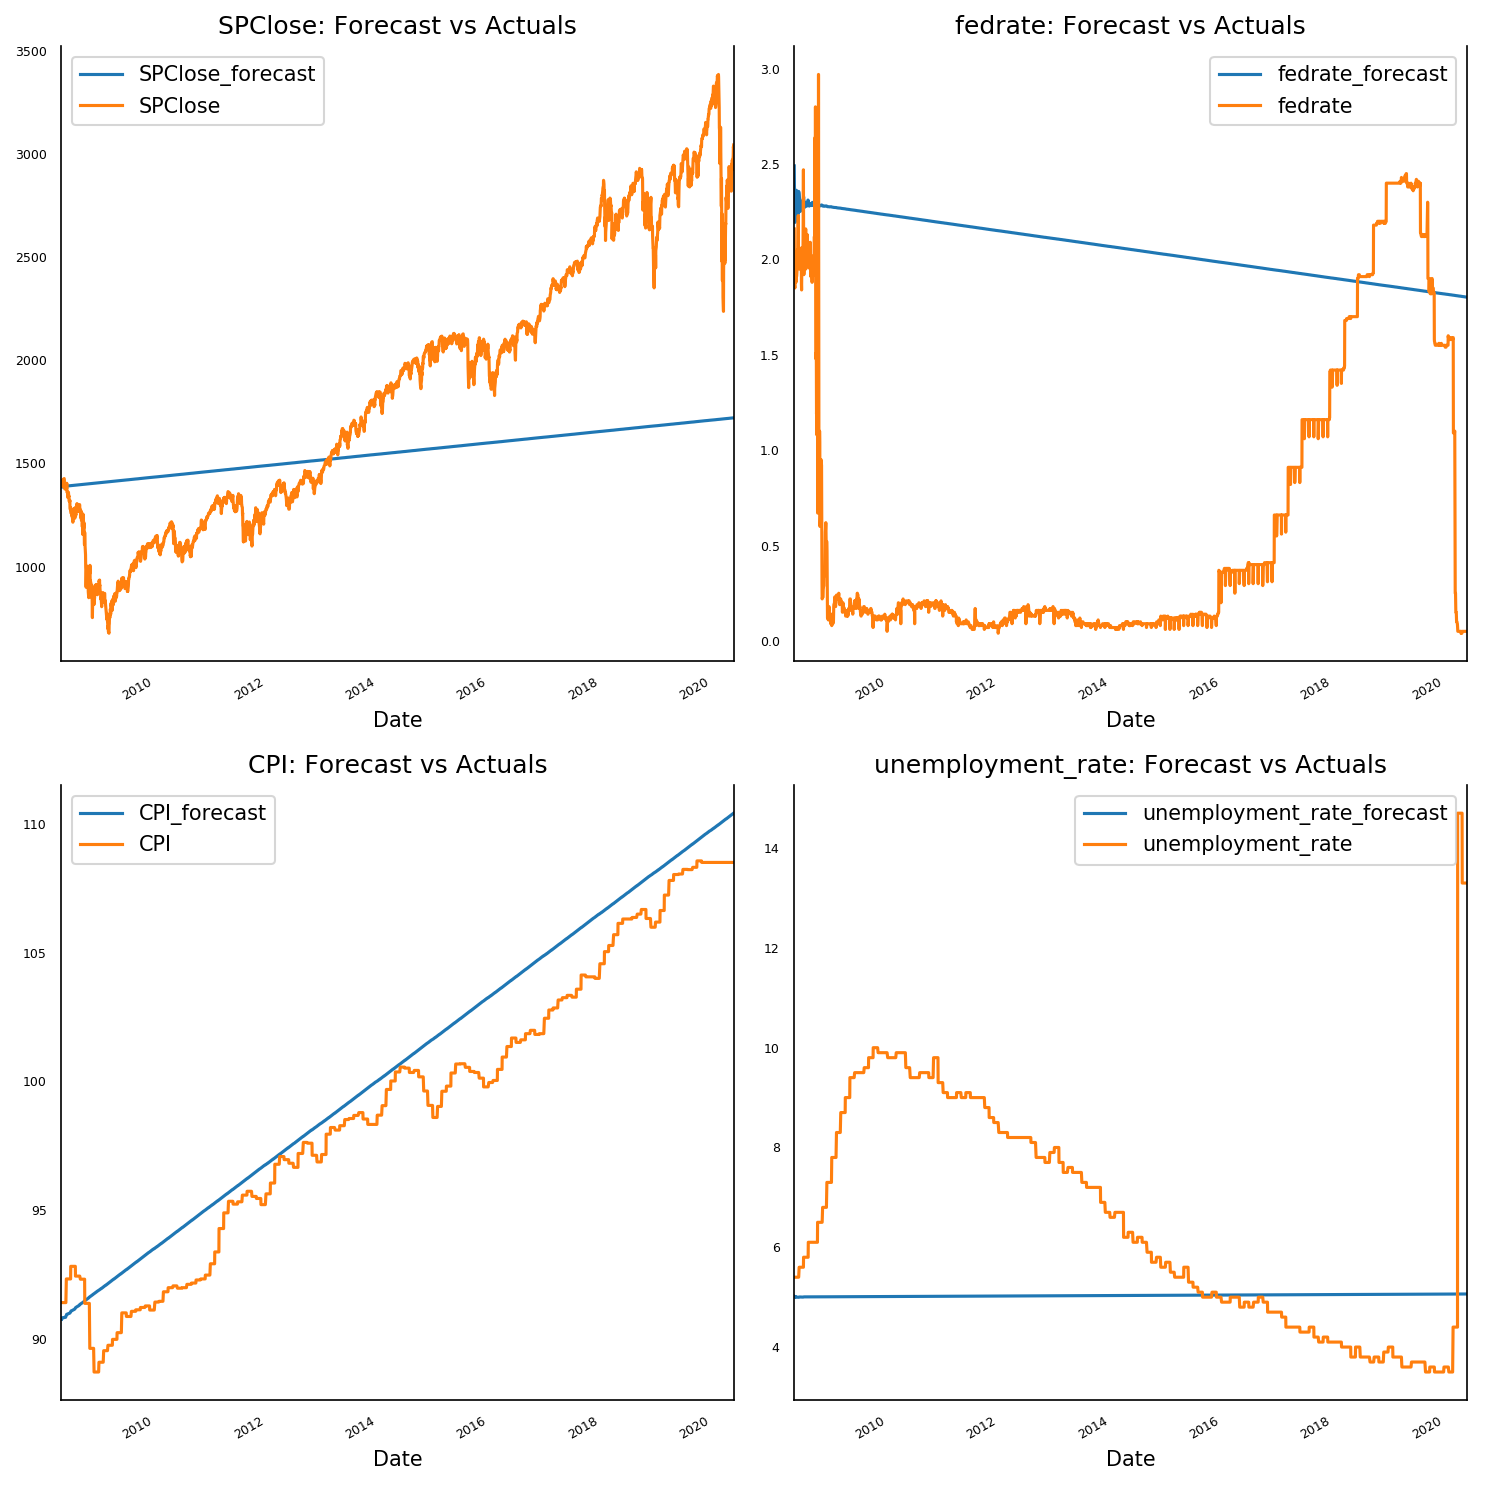

In [274]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [293]:
#  forecast on test + 10 years

nobs1=int(len(df)*0.2)+3650

fc1 = model_fitted.forecast(y=forecast_input, steps=nobs1)
df_forecast1 = pd.DataFrame(fc1, columns=df.columns + '_1d',
                           index=pd.date_range(start='2008-05-01', periods=len(fc1), freq='D'))
df_forecast1

,SPClose_1d,fedrate_1d,CPI_1d,unemployment_rate_1d
2008-05-01,0.304965,0.120650,0.108022,0.014393
2008-05-02,3.684527,-0.099036,0.055716,-0.004412
2008-05-03,-0.184691,-0.153083,0.000699,-0.004562
2008-05-04,0.321478,-0.044043,-0.006941,-0.002678
2008-05-05,1.542922,0.070505,0.000303,0.003782
...,...,...,...,...
2026-08-21,0.109697,-0.000165,0.006464,0.000019
2026-08-22,0.109697,-0.000165,0.006464,0.000019
2026-08-23,0.109697,-0.000165,0.006464,0.000019
2026-08-24,0.109697,-0.000165,0.006464,0.000019


In [294]:
df_results1 = invert_transformation(train, df_forecast1)

In [296]:
df_results1.drop(['SPClose_1d', 'fedrate_1d', 'CPI_1d', 'unemployment_rate_1d'], axis=1, inplace=True)

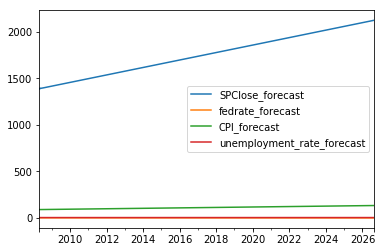

In [297]:
df_results1.plot()

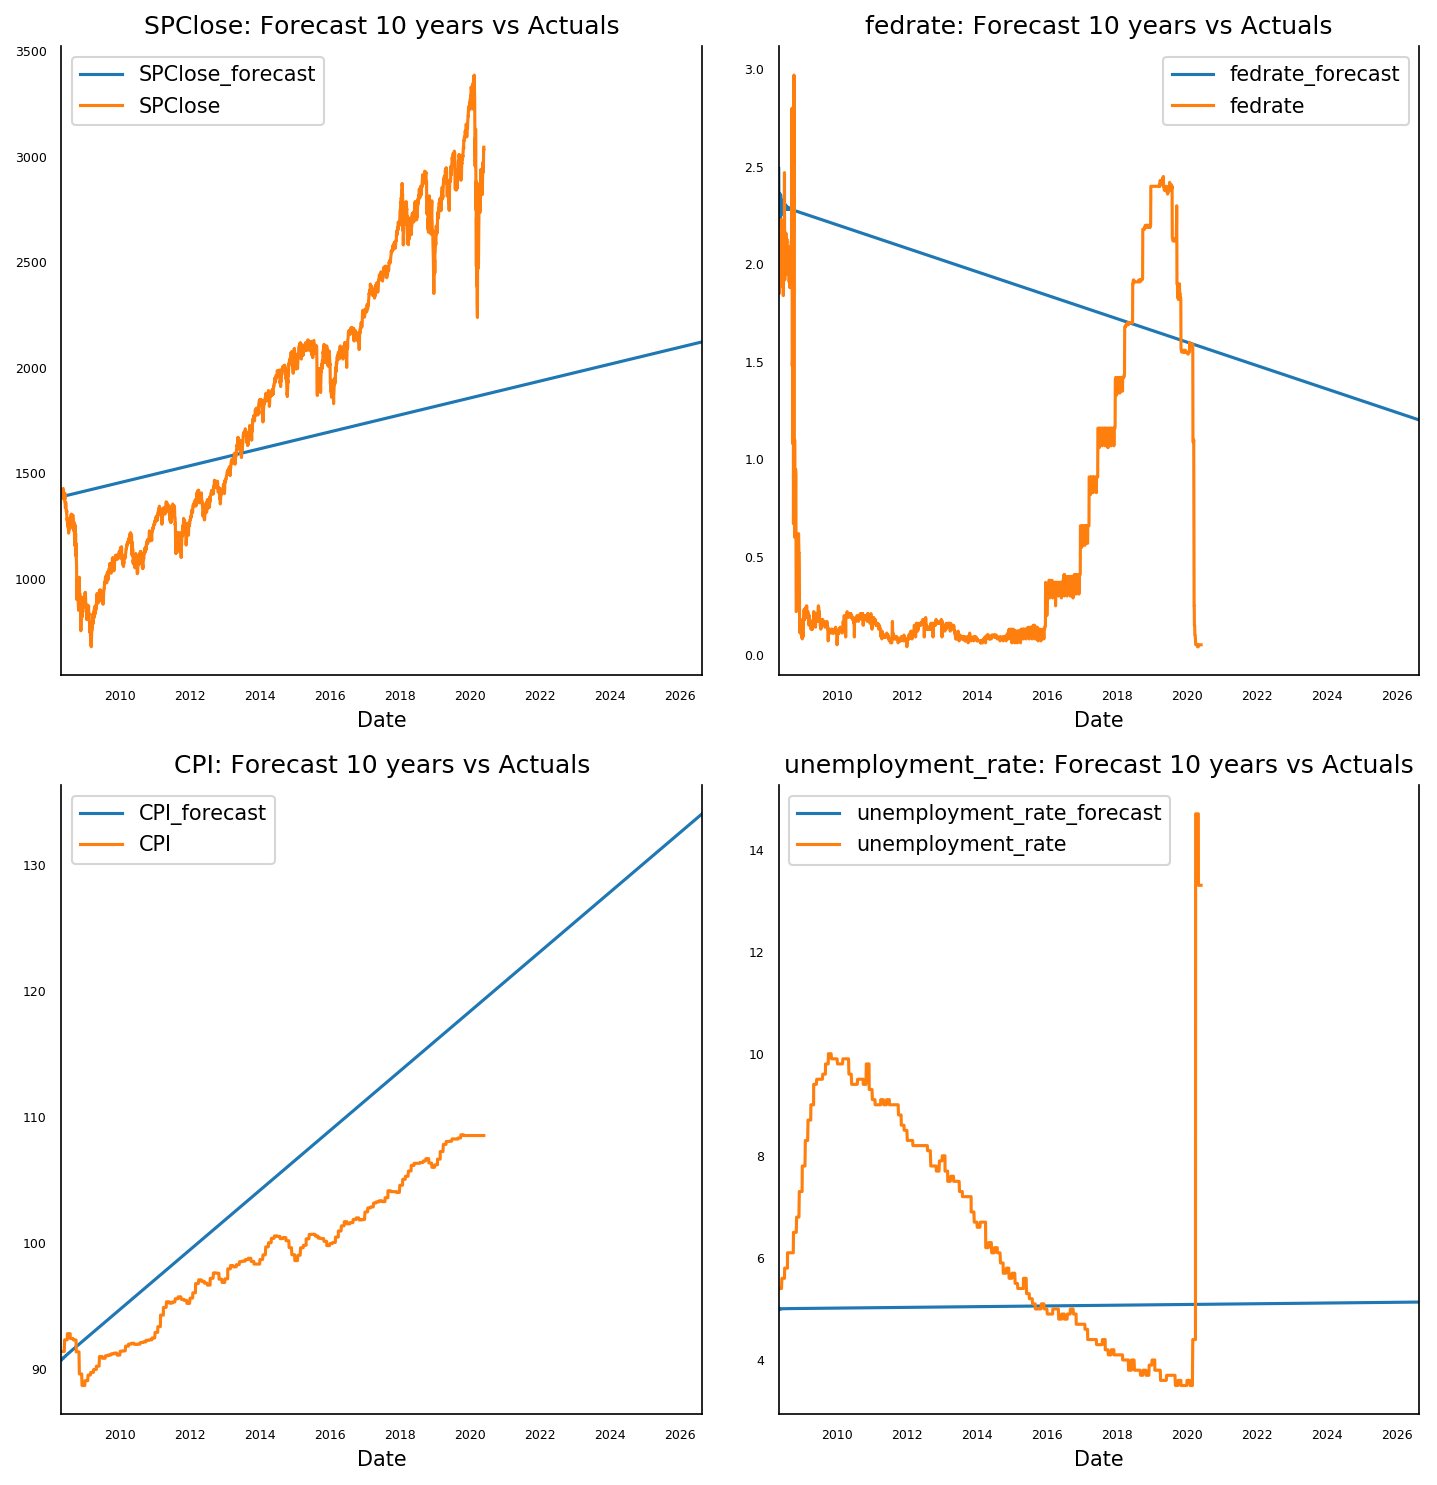

In [298]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results1[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast 10 years vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Summary

From both ARIMA model and VAR model, we are able to conclude the following;
1. The S&P500 index will increase in the long run 
2. The S&P500 index forecast line is smooth. 
It is because the time period in the training and testing sets are farily long, which stretch out and smooth out the forecasting line. 
If I want to have a more curved and fitted line, I may repeat the process year by year, but that is sort of forfeit the purpose of looking into the long term picture.
3. The forecasting is not able to include the major events, such as the recent covid effect on the market.
4. The other factors addressed in Q2 (federal interest rate, Consumer Price Index (CPI), and unemployment rate) did not affect SP500 Index significantly as the forcasting lines in both models are similar.

The takeaway is that instead of focusing on day trading or speculating the market, investors could choose the 'buy and hold' strategy due to the long term positive return. And based on the market volitility and investors' risk tolerance, investors can add on some hedging strategy if they wish.

According to a research report published by several university professors, only about 13% of day traders earn a net profit in any given year. Even worse, less than 1% of day traders are consistently profitable year after year.

On the other side, the S&P 500 historically has rewarded investors with total returns averaging about 9.5% per year -- even when factoring in the bad years.

So it is save to say focusing on S&P500 trends in the mid to long term is good for our decision making process.
